In [2]:
import os
import sys
if 'notebooks' in os.getcwd():
    os.chdir("..")
    sys.path.append(os.getcwd())
    print("Changed path to", os.getcwd())

Changed path to /home/jovyan/swe_forecasting_prod


In [24]:
from random import random
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [25]:
class ETHoleTiny:
    def __init__(self):
        '''
        Initialize a tiny wormhole ET regressor.
        '''
        regressor = ExtraTreesRegressor(n_jobs=-1, random_state=123)
        scaler = StandardScaler()

        self.model = Pipeline(steps=[
            ("data_scaling", scaler),
            ("model", regressor)
        ])

        self.train_x        = None
        self.train_y        = None
        self.test_x         = None
        self.test_y         = None
        self.test_y_result  = None
        self.train_y_result = None
        self.features       = None

    def preprocess_data(self, filepath, chosen_columns=None, sample=1, verbose=False):
        '''
        Preprocess a dataset at filepath, split it, and save
        the resulting arrays to this object.
        '''
        if verbose: print("Using file", filepath)
        data = pd.read_csv(filepath)
        if verbose: print("Shape:", data.shape)

        # Convert date to season
        data["date"] = (pd.to_datetime(data["date"]).dt.month-1) % 3

        # Replace NAs
        data.replace("--", pd.NA, inplace=True)
        data.fillna(-999, inplace=True)
        data = data[data["swe_value"]!=-999]

        if chosen_columns is None:
            # Discard non-numeric columns
            non_numeric = data.select_dtypes(exclude=["number"]).columns
            if verbose: print("Dropping non-numeric columns:", non_numeric)
            data = data.drop(columns=non_numeric)
            # Also drop date, lat, lon
            data = data.drop(columns=["date", "lat", "lon"])
        else:
            data = data[chosen_columns]

        X = data.drop("swe_value", axis=1)
        if verbose: print("Using features", X.columns)
        y = data["swe_value"]

        if verbose:
            print("Descriptive statistics")
            print("-- Training data --")
            print(X.describe())
            print("-- Target data --")
            print(y.describe())

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        self.train_x = X_train
        self.train_y = y_train
        self.test_x  = X_test
        self.test_y  = y_test
        self.features = X_train.columns

    def fit(self):
        '''
        Train model and store results.
        '''
        self.model.fit(self.train_x, self.train_y)
        self.train_y_result = self.model.predict(self.train_x)
        self.test_y_result = self.model.predict(self.test_x)

    def evaluate(self):
        '''
        Evaluate model output with MAE, RMSE, and R2.
        '''
        if self.test_y_result is None:
            raise RuntimeError("Model must be trained before evaluating!")

        return {
            "rmse": metrics.root_mean_squared_error(self.test_y, self.test_y_result),
            "mae": metrics.mean_absolute_error(self.test_y, self.test_y_result),
            "r2": metrics.r2_score(self.test_y, self.test_y_result)
        }

    def predict(self, input_x):
        '''
        Run model on new data.
        '''
        return self.model.predict(input_x)
    

In [26]:
et = ETHoleTiny()

In [27]:
smallfile = "/home/jovyan/shared-public/ml_swe_monitoring_prod/snotel_ghcnd_stations_4yrs_all_cols_small.csv"

In [28]:
chosen_columns = [
  'swe_value',
  'cumulative_SWE',
  'fsca',
  'air_temperature_tmmx', 
  'air_temperature_tmmn', 
  'potential_evapotranspiration', 
  'relative_humidity_rmax', 
  'Elevation',	
  'Slope',	
  'Curvature',	
  'Aspect',	
  'Eastness',	
  'Northness',
]

et.preprocess_data(smallfile, verbose=True, chosen_columns=chosen_columns)

Using file /home/jovyan/shared-public/ml_swe_monitoring_prod/snotel_ghcnd_stations_4yrs_all_cols_small.csv
Shape: (10000, 105)
Using features Index(['cumulative_SWE', 'fsca', 'air_temperature_tmmx',
       'air_temperature_tmmn', 'potential_evapotranspiration',
       'relative_humidity_rmax', 'Elevation', 'Slope', 'Curvature', 'Aspect',
       'Eastness', 'Northness'],
      dtype='object')
Descriptive statistics
-- Training data --
       cumulative_SWE         fsca  air_temperature_tmmx  \
count     6774.000000  6774.000000           6774.000000   
mean         0.136495     5.948830            217.309994   
std          1.757386    17.304665            126.301994   
min         -1.000000     0.000000              0.000000   
25%         -1.000000     0.000000              0.000000   
50%         -1.000000     0.000000            286.100000   
75%          1.820106     0.000000            295.775147   
max          4.371002    93.000000            320.000000   

       air_temperatur

In [29]:
et.fit()

In [30]:
et.evaluate()

{'rmse': 3.445828786815195,
 'mae': 1.0731719557195574,
 'r2': 0.4738548492798256}

In [53]:
predict_data = pd.read_csv("/home/jovyan/shared-public/ml_swe_monitoring_prod/test_data_predicted_latest_2023-12-15_REDUCEDPNW.csv")
predict_data = predict_data.dropna(subset=chosen_columns[1:])

In [54]:
predict_data.shape

(6468, 254)

In [56]:
predict_data["small_et_predict"] = et.predict(predict_data[chosen_columns[1:]])

In [70]:
predict_data.columns.values

array(['Unnamed: 0', 'lat', 'lon', 'relative_humidity_rmax',
       'mean_vapor_pressure_deficit', 'relative_humidity_rmin',
       'precipitation_amount', 'wind_speed',
       'potential_evapotranspiration', 'air_temperature_tmmx',
       'air_temperature_tmmn', 'x', 'y', 'Elevation', 'Slope', 'Aspect',
       'Curvature', 'Northness', 'Eastness', 'AMSR_SWE_2023-10-01',
       'AMSR_Flag_2023-10-01', 'AMSR_SWE_2023-10-02',
       'AMSR_Flag_2023-10-02', 'AMSR_SWE_2023-10-03',
       'AMSR_Flag_2023-10-03', 'AMSR_SWE_2023-10-04',
       'AMSR_Flag_2023-10-04', 'AMSR_SWE_2023-10-05',
       'AMSR_Flag_2023-10-05', 'AMSR_SWE_2023-10-06',
       'AMSR_Flag_2023-10-06', 'AMSR_SWE_2023-10-07',
       'AMSR_Flag_2023-10-07', 'AMSR_SWE_2023-10-08',
       'AMSR_Flag_2023-10-08', 'AMSR_SWE_2023-10-09',
       'AMSR_Flag_2023-10-09', 'AMSR_SWE_2023-10-10',
       'AMSR_Flag_2023-10-10', 'AMSR_SWE_2023-10-11',
       'AMSR_Flag_2023-10-11', 'AMSR_SWE_2023-10-12',
       'AMSR_Flag_2023-10-12', '

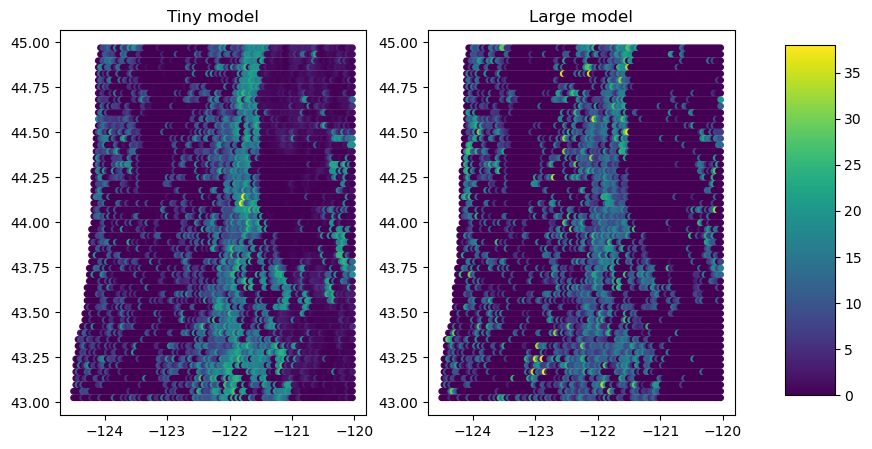

In [77]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sc = ax1.scatter(predict_data.lon, predict_data.lat, c=predict_data.small_et_predict, s=15)
ax1.title.set_text("Tiny model")
_  = ax2.scatter(predict_data.lon, predict_data.lat, c=predict_data.predicted_swe, s=15)
ax2.title.set_text("Large model")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc, cax=cbar_ax)

plt.show()

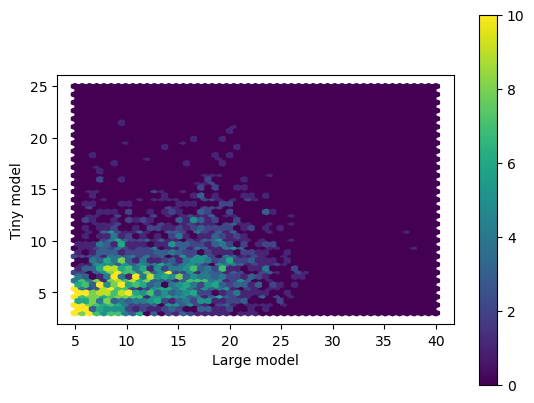

In [85]:
plt.hexbin(predict_data.small_et_predict, predict_data.predicted_swe, vmax=10,
          extent=(5, 40, 3, 25), gridsize=50)
plt.xlabel("Large model")
plt.ylabel("Tiny model")
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

In [84]:
?plt.hexbin

Signature:
plt.hexbin(
    x: 'ArrayLike',
    y: 'ArrayLike',
    C: 'ArrayLike | None' = None,
    gridsize: 'int | tuple[int, int]' = 100,
    bins: "Literal['log'] | int | Sequence[float] | None" = None,
    xscale: "Literal['linear', 'log']" = 'linear',
    yscale: "Literal['linear', 'log']" = 'linear',
    extent: 'tuple[float, float, float, float] | None' = None,
    cmap: 'str | Colormap | None' = None,
    norm: 'str | Normalize | None' = None,
    vmin: 'float | None' = None,
    vmax: 'float | None' = None,
    alpha: 'float | None' = None,
    linewidths: 'float | None' = None,
    edgecolors: "Literal['face', 'none'] | ColorType" = 'face',
    reduce_C_function: 'Callable[[np.ndarray | list[float]], float]' = <function mean at 0x7f34bab47930>,
    mincnt: 'int | None' = None,
    marginals: 'bool' = False,
    *,
    data=None,
    **kwargs,
) -> 'PolyCollection'
Docstring:
Make a 2D hexagonal binning plot of points *x*, *y*.

If *C* is *None*, the value of the hexagon is 